## 神经网络

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #读取 *.mat文件
import scipy.misc #把矩阵以图片形式展现
import matplotlib.cm as cm #画图
import random
import scipy.optimize #fmin_cg训练神经网络
import itertools
from scipy.special import expit #Sigmoid函数
from sklearn.model_selection import train_test_split #切割训练集与测试集

### 手写数字预览数据预览

In [2]:
datafile =  'data/ex4data.mat'
mat = scipy.io.loadmat(datafile)
X,y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print("X.shape:{};y.shape:{};Unique elements in y:{})".format(X.shape,y.shape,np.unique(y)))

X.shape:(5000, 401);y.shape:(5000, 1);Unique elements in y:[ 1  2  3  4  5  6  7  8  9 10])


In [3]:
#切割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [13]:
def getDatumImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.axis('off')
    plt.imshow(img,cmap = cm.Greys_r)

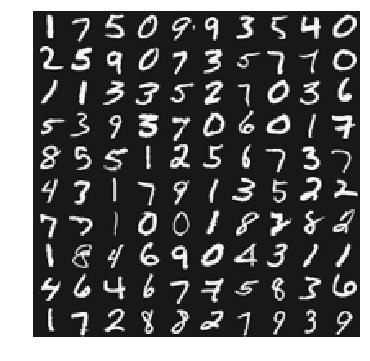

In [14]:
displayData()

### 模型表示(Model Representation)

In [15]:
#有训练好的现成的参数(Θ(1),Θ(2)) 
datafile = 'data/ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# Theta1 （25 x 401）
# Theta2 （10 x 26）

In [16]:
def flattenParams(thetas_list):
    """
    Hand this function a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

In [65]:
#定义下面全局变量，用于确定计算过程中矩阵的shape是正确的，不含bias unit
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X_train.shape[0]

In [18]:
def propagateForward(row,Thetas):
    feature = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):
        theta = Thetas[i]
        z = np.dot(feature,theta.T).reshape(theta.shape[0],1)
        a = expit(z)
        zs_as_per_layer.append((z, a))
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add bias unit
        feature = a.T

In [19]:
def computeCost(myThetas,myX,myy,mylambda=0.):
    myThetas = reshapeParams(myThetas)
    myX = reshapeX(myX)
    m = n_training_samples
    total_cost = 0.
    for i in range(m):
        myrow = myX[i]
        myhs = propagateForward(myrow,myThetas)[-1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[i]-1] = 1
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
        total_cost += mycost
    total_cost = float(total_cost)/m
    total_reg = 0.
    for theta in myThetas:
        total_reg += np.sum(np.multiply(theta,theta))
    total_reg *= float(mylambda)/(2*m)
    return total_cost + total_reg

In [21]:
myThetas = [ Theta1, Theta2 ]
computeCost(flattenParams(myThetas),X,y,mylambda=0)

0.28762916516131876

正则化的代价函数得到的结果

In [23]:
computeCost(flattenParams(myThetas),X,y,mylambda=1)

0.38448779624289381

### 反向传播

sigmoid函数求导

In [24]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

随机初始化参数

In [25]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init,
                  np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

反向传播

In [40]:
def backPropagate(myThetas,myX,myy,mylambda=0.):
    myThetas = reshapeParams(myThetas)
    m = n_training_samples
    myX = reshapeX(myX)
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))
    for i in range(m):
        myrow = myX[i]
        a1 = myrow.reshape((input_layer_size+1,1))
        temp = propagateForward(myrow,myThetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[i]-1] = 1
        delta3 = a3 - tmpy
        delta2 = myThetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2)
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T)
        Delta2 += delta3.dot(a2.T)
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*myThetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*myThetas[1][:,1:]
    return flattenParams([D1, D2]).flatten()

In [42]:
D1, D2 = reshapeParams(backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.))

梯度检测

In [35]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [36]:
checkGradient(myThetas,[D1, D2],X,y)

Element: 2636. Numerical Gradient = 0.000172. BackProp Gradient = 0.000172.
Element: 3371. Numerical Gradient = -0.000067. BackProp Gradient = -0.000067.
Element: 1622. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 8180. Numerical Gradient = 0.000012. BackProp Gradient = 0.000012.
Element: 195. Numerical Gradient = -0.000107. BackProp Gradient = -0.000107.
Element: 7837. Numerical Gradient = -0.000103. BackProp Gradient = -0.000103.
Element: 6519. Numerical Gradient = 0.000026. BackProp Gradient = 0.000026.
Element: 5574. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 10085. Numerical Gradient = 0.000464. BackProp Gradient = 0.000464.
Element: 662. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.


用fmincg函数训练数据

In [66]:
def trainNN(mylambda=0.):
    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(X_train,y_train,mylambda),maxiter=50,disp=True,full_output=True)
    return reshapeParams(result[0])

In [67]:
learned_Thetas = trainNN()

         Current function value: 0.223970
         Iterations: 50
         Function evaluations: 118
         Gradient evaluations: 118


In [59]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = list(range(1,10)) + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [70]:
computeAccuracy(X_test,learned_Thetas,y_test)

Training set accuracy: 93.9%


In [71]:
learned_regularized_Thetas = trainNN(mylambda=1.)

         Current function value: 0.473384
         Iterations: 50
         Function evaluations: 108
         Gradient evaluations: 108


In [72]:
computeAccuracy(X_test,learned_regularized_Thetas,y_test)

Training set accuracy: 92.4%
